In [78]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from predictions import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import load_model

In [6]:
def emd_lstm_train(model_name, x_train, y_train, x_val, y_val, window_size, data_types, lstms=5, epochs=10, learning_rate=0.0001):
    for i in range(lstms):
        model = Sequential()
        model.add(InputLayer((window_size, len(data_types))))
        model.add(LSTM(64))
        model.add(Dense(8, 'relu'))
        model.add(Dense(1, 'linear'))

        # Save best fit models to model/ directory
        cp = ModelCheckpoint(f'model/lstm_diff/{model_name}_{i}.keras', save_best_only=True)
        model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError()])

        # Training
        model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, callbacks=[cp])

        # Update the anticipated outputs
        y_train = np.copy(y_train - model.predict(x_train).flatten())
        y_val = np.copy(y_val - model.predict(x_val).flatten())

def emd_lstm_predict(model_name, x):
    matching_filenames = []
    for filename in os.listdir('model/lstm_diff/'):
        if filename.startswith(f"{model_name}_"):
            matching_filenames.append(filename)

    predictions = []
    for i in range(0, len(matching_filenames)):
        model = load_model(f'model/lstm_diff/{model_name}_{i}.keras')
        predictions.append(model.predict(x).flatten())

    return predictions




def as_yesterday_predict(x):
    assert all(len(item) >= 24 for item in x)
    return [vals[-24][-1] for vals in x]

def as_last_hour_predict(x):
    return [vals[-1][-1] for vals in x]

def mse(a,b):
    return (np.square(a - b)).mean()

In [131]:
# Variables[
# Temperature must be last in data_types
data_types = ["humidity", "pressure", "temperature"] # Data used for prediction]
window_size = 5

data = get_data(data_types)
cities_dict = list_by_cities(data, data_types)

# x_y_by_cities is a dict with city names as keys
# and values are tuples (x, y)
x_y_by_cities= df_to_X_y(cities_dict,window_size)
x, y = get_x_y_from_cities(x_y_by_cities, ["Kansas City", "Saint Louis", "Chicago", ])

# Divide the data
x_train, y_train, x_val, y_val, x_test, y_test = \
    divide_data(x, y , train_pc=0.8, val_pc=0.1)

Merge city data: 100%|██████████| 36/36 [00:00<00:00, 125.34it/s]


In [127]:
# # model_name saved in ./model/lstm_diff dir
model_name = "5ep_5lstms_all-cities_5h"

In [35]:

# # !!! run_lstm_model() overwrites the older model with the same name
learning_rate = 0.001
num_of_epochs = 5
num_of_lstms = 5
#run_lstm_model(model_name, x_train, y_train, x_val, y_val, window_size, data_types, epochs=num_of_epochs, learning_rate=learning_rate)
#lstm_prediction = lstm_predict(model_name, x_test)


emd_lstm_train(model_name, x_train, y_train, x_val, y_val, window_size, data_types, lstms=num_of_lstms, epochs=num_of_epochs, learning_rate=learning_rate)

Epoch 1/5
40724/40724 ━━━━━━━━━━━━━━━━━━━━ 177s 4ms/step - loss: 8906.3135 - root_mean_squared_error: 80.9701 - val_loss: 71.9891 - val_root_mean_squared_error: 8.4846
Epoch 2/5
40724/40724 ━━━━━━━━━━━━━━━━━━━━ 170s 4ms/step - loss: 25.3999 - root_mean_squared_error: 4.9292 - val_loss: 10.4818 - val_root_mean_squared_error: 3.2376
Epoch 3/5
40724/40724 ━━━━━━━━━━━━━━━━━━━━ 144s 4ms/step - loss: 6.9406 - root_mean_squared_error: 2.6262 - val_loss: 3.9225 - val_root_mean_squared_error: 1.9805
Epoch 4/5
40724/40724 ━━━━━━━━━━━━━━━━━━━━ 166s 4ms/step - loss: 3.1861 - root_mean_squared_error: 1.7849 - val_loss: 3.4806 - val_root_mean_squared_error: 1.8656
Epoch 5/5
40724/40724 ━━━━━━━━━━━━━━━━━━━━ 341s 8ms/step - loss: 3.1237 - root_mean_squared_error: 1.7673 - val_loss: 5.4361 - val_root_mean_squared_error: 2.3316
40724/40724 ━━━━━━━━━━━━━━━━━━━━ 216s 5ms/step
5091/5091 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step
Epoch 1/5
40724/40724 ━━━━━━━━━━━━━━━━━━━━ 451s 11ms/step - loss: 2.2753 - root_mean_sq

In [132]:
emd_lstm_prediction = emd_lstm_predict(model_name, x_test)
alh = as_last_hour_predict(x_test)

425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
425/425 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [120]:
plot_beginning = 0

In [133]:
colormap = plt.get_cmap('winter')
num_colors = len(emd_lstm_prediction)

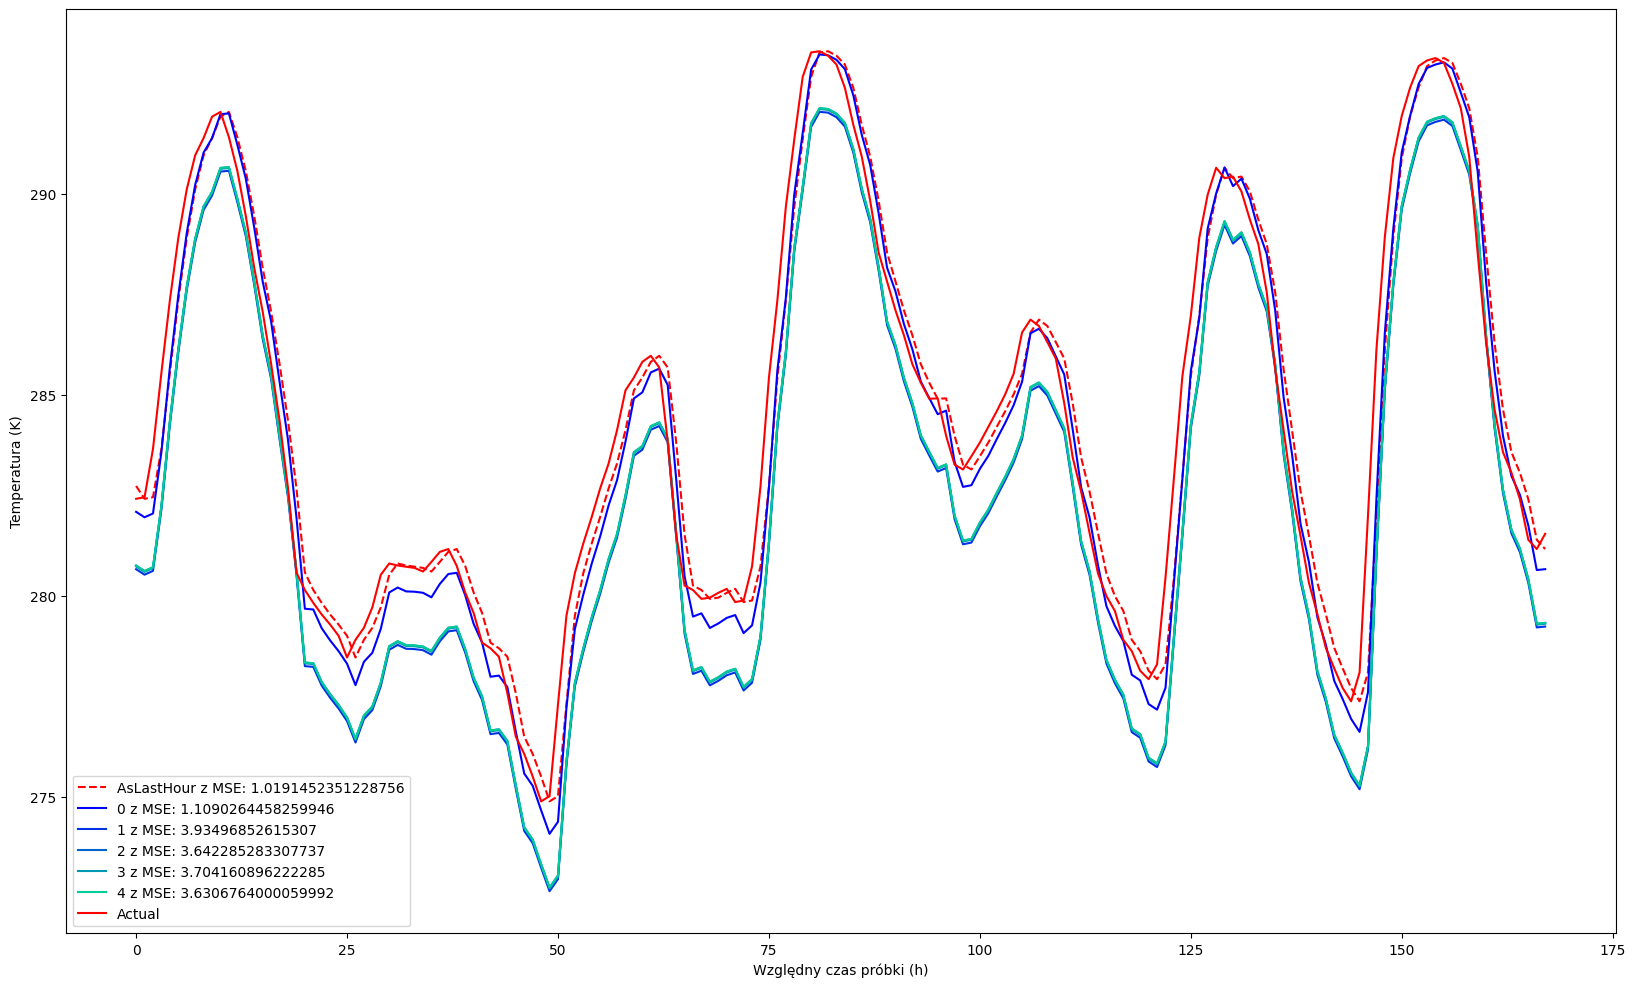

In [134]:

y_sum = np.zeros(emd_lstm_prediction[0].shape)
mse_list = list()
plt.figure(figsize=(20, 12))
plt.plot(alh[plot_beginning: plot_beginning + 24*7], "--r")
for i, lstm_y in enumerate(emd_lstm_prediction):
    y_sum += lstm_y
    mse_list.append(f"{i} z MSE: {mse(y_test, y_sum)}")
    color = colormap(i / num_colors)
    plt.plot(y_sum[plot_beginning: plot_beginning + 24*7], color=color)
plt.plot(y_test[plot_beginning: plot_beginning + 24*7], "r")
plt.legend([ f"AsLastHour z MSE: {mse(y_test, alh)}", *mse_list, "Actual"])
plt.xlabel("Względny czas próbki (h)")
plt.ylabel("Temperatura (K)")
plt.draw()

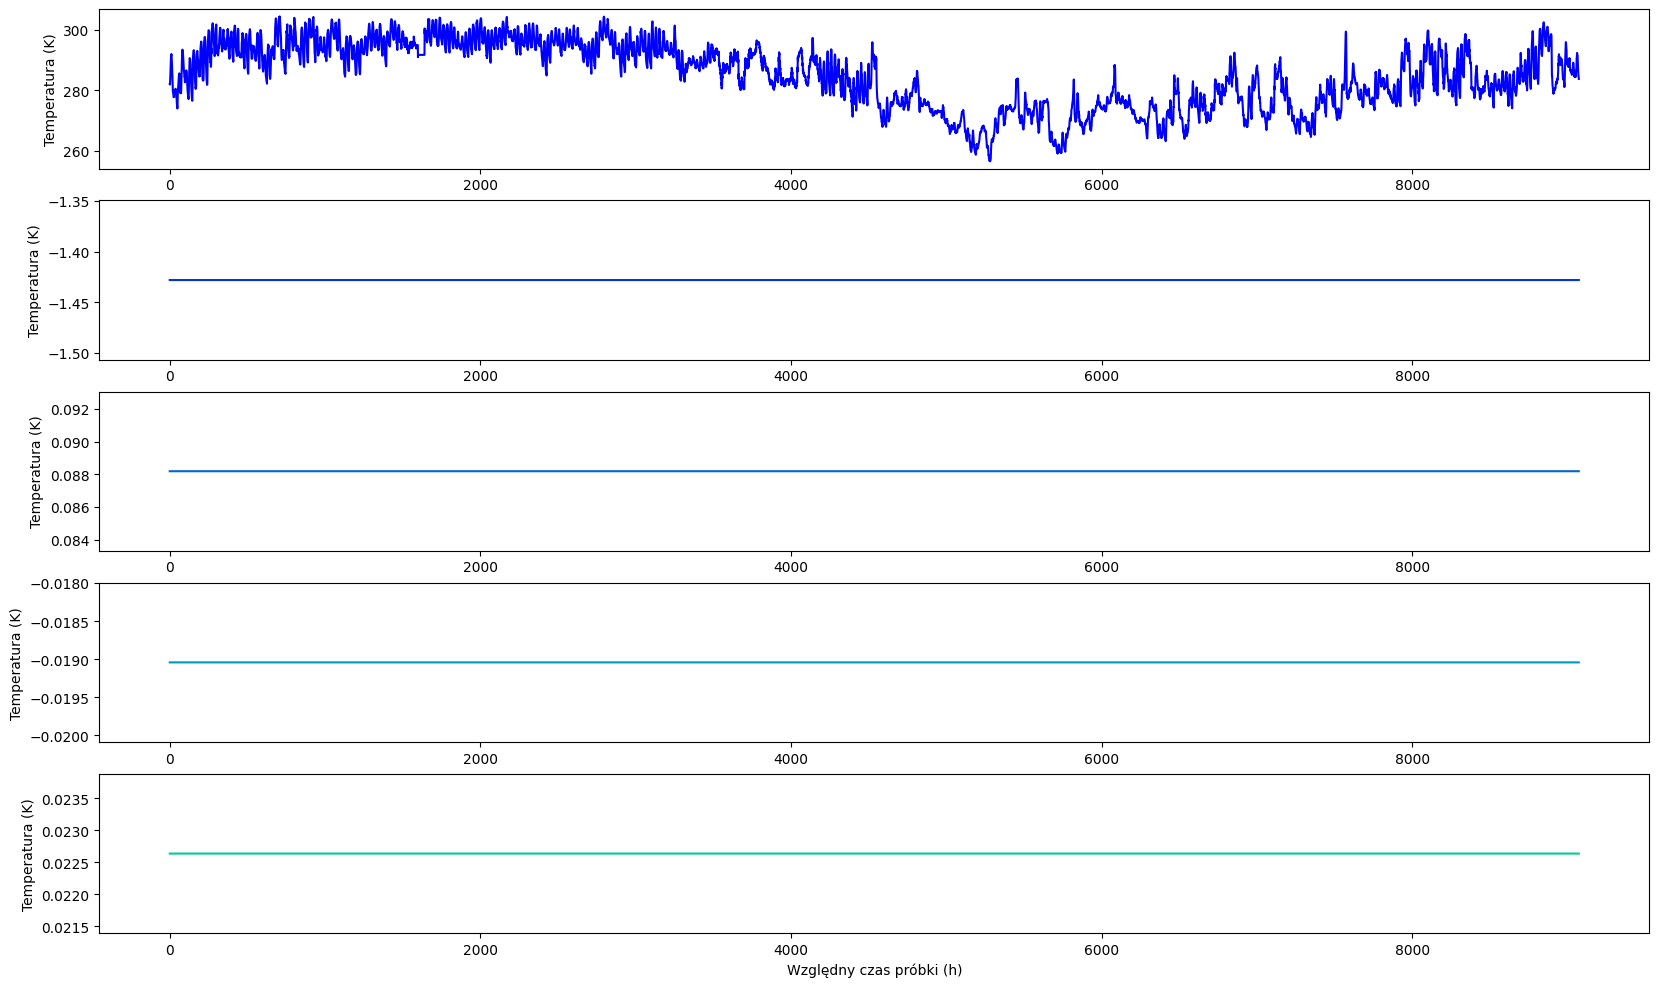

In [135]:
plt.figure(figsize=(20, 12))
for i, imf in enumerate(emd_lstm_prediction):
    plt.subplot(len(emd_lstm_prediction),1,i+1)
    color = colormap(i / num_colors)
    plt.plot(imf[plot_beginning: plot_beginning + 54*24*7], color=color)
    plt.ylabel("Temperatura (K)")
plt.xlabel("Względny czas próbki (h)")
plt.draw()